# Set Up Enviornment

In [ ]:
!nvidia-smi

In [ ]:
# Importing stock ml libraries
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import json
import logging
import matplotlib.pyplot as plt
import uuid

# Sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Gensim
from gensim import corpora
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

logging.basicConfig(level=logging.ERROR)

In [ ]:
from google.colab import drive
import os

# Setup work directory
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Dissertation/')
os.listdir() # overview the files

Mounted at /content/drive


['stopwords_zh-tw.txt',
 'Manifestos_RawData',
 'Manifesto_Data_Tagger',
 'Manifesto_Data_Transformer',
 'Vote_Data',
 'Final_Data',
 'Result_1',
 'Graph',
 '碩士論文研究計畫書.docx']

## Hyperparameters

In [ ]:
FILE_PATH = '/content/drive/MyDrive/Dissertation/Final_Data/Manifesto_Data_Tagger.xlsx'
SEED = 42

## Load dataset

In [ ]:
def load_data(file_path):
    df = pd.read_excel(file_path)
    num_rows = len(df)
    uuids = [str(uuid.uuid4()) for _ in range(num_rows)]

    df.insert(0, 'id', uuids)
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

In [ ]:
df = load_data(FILE_PATH)
df.head(2)

,id,LNAME,TH,AREA,ABORIGINE,PARTY,PARTY_CODE,GENDER,AGE,INCUMBENT,...,ELE,BYELE,VOTES,VOTER_TURNOUT,CONTENT,SENTENCE,TOKEN,ENOUGH_VOTE,MAIN_PARTY_MEMBER,SERIOUS_CANDIDATE
0,33bceaa4-53df-412c-84fb-76fda1fe7a29,丁守中_4,4,台北市第一選區,0,國民黨,1,1,-1,1,...,1,0,75773,10.02,守中擔任立委九年來，媒體、社團、民調歷次評鑑，始終列名問政表現最績優的立委，說明守中理性專業...,守中 擔任 立委 媒體 社團 民調 歷次 評鑑 始終 列名 問政 表現 績優 立委 說明 守...,守中 擔任 立委 媒體 社團 民調 歷次 評鑑 始終 列名 問政 表現 績優 立委 說明 守...,True,True,1
1,c08a47aa-64f8-44ab-afa9-397f837f11d2,于樹潔_4,4,高雄市第二選區,0,新黨,4,0,-1,0,...,0,0,16771,4.79,一、捍衛中華民國，確保台海安全。二、拓展兩岸關係，力主三通直航。三、維護法律尊嚴，強化貴任政...,捍衛 中華民國 確保 台海 安全 拓展 兩岸 關係 力主 三通 直航 維護 法律 尊嚴 強化...,捍衛 中華民國 確保 台海 安全 拓展 兩岸 關係 力主 三通 直航 維護 法律 尊嚴 強化...,True,True,1


In [ ]:
df.shape

(2489, 21)

### Data Length

In [ ]:
def plot_length_distribution(df, col_name: str, max_length=False):
    text_lengths = df[col_name].str.len()

    plt.figure(figsize=(10, 6))
    if max_length:
        max_length = text_lengths.quantile(0.99)
        plt.hist(text_lengths[text_lengths <= max_length], bins=100, color='#a6998a', alpha=0.7, edgecolor='black')
    else:
        plt.hist(text_lengths, bins=100, color='#a6998a', alpha=0.7, edgecolor='black')

    plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

    plt.title('Text Length Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Text Length', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)

    plt.xticks(fontsize=10, rotation=15)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()


In [ ]:
plot_length_distribution(df, 'TOKEN')

# Preprocessing



In [ ]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = [line.strip() for line in file]
    return set(stopwords)

stopwords = load_stopwords('stopwords_zh-tw.txt')

In [ ]:
def remove_stopwords(token_str, stopwords):
    words = token_str.split()
    filtered_words = [word for word in words if word not in stopwords]
    return ' '.join(filtered_words)

# 應用到DataFrame的TOKEN欄位
df['TOKEN'] = df['TOKEN'].apply(lambda x: remove_stopwords(x, stopwords))
df['TOKEN'] = df['TOKEN'].apply(lambda x: x.split())

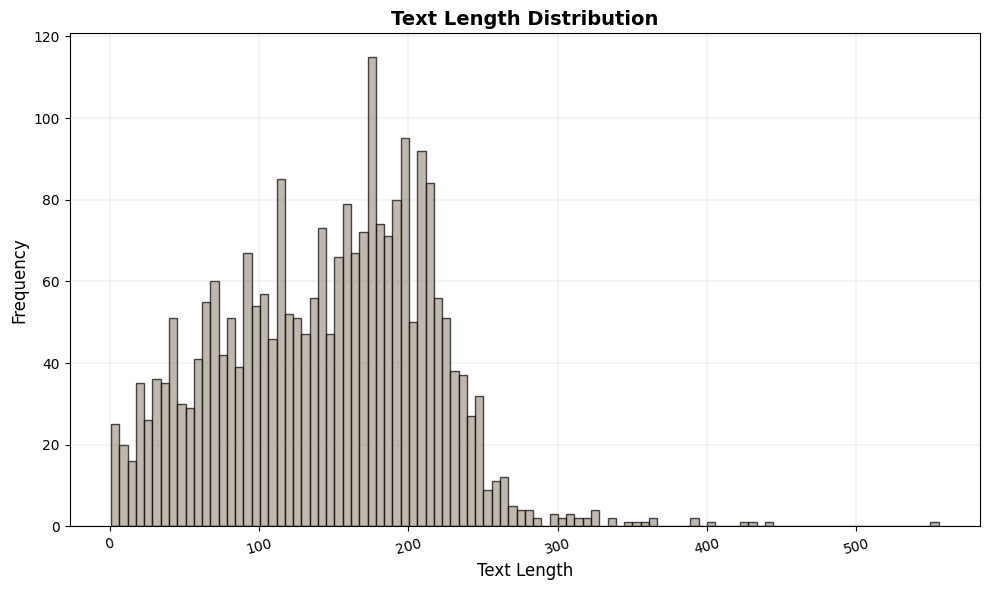

In [ ]:
plot_length_distribution(df, 'TOKEN')

# Train

In [ ]:
def train(data, num_topics=50, lr=1, passes=5, random_state=SEED):
    dictionary = corpora.Dictionary(data)
    corpus = [dictionary.doc2bow(text) for text in data]
    nmf_model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, kappa=lr, passes=passes, random_state=random_state)

    return nmf_model, corpus, dictionary

In [ ]:
nmf_model, corpus, dictionary = train(df['TOKEN'])

In [ ]:
def topic_df(model, num_words=10):
    topics = {i: [word for word, prob in model.show_topic(i, num_words)] for i in range(model.num_topics)}
    return pd.DataFrame(topics)

## Grid Search Best Topic Number

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, kappa_range, start=30, step=5, limit=70, random_state=SEED):
    coherence_dict = {kappa: [] for kappa in kappa_range}
    model_list = []
    best_topic_num = -1
    best_coherence = -100
    best_kappa = -1

    for kappa in kappa_range:
        for num_topics in tqdm(range(start, limit, step), desc=f"Training models with kappa={kappa}"):
            model = Nmf(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=random_state, passes=5, kappa=kappa)
            model_list.append((model, num_topics, kappa))
            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence = coherencemodel.get_coherence()
            coherence_dict[kappa].append(coherence)

            if coherence > best_coherence:
                best_coherence = coherence
                best_topic_num = num_topics
                best_kappa = kappa

    print(f"\nBest topic number: {best_topic_num}, Best kappa: {best_kappa}")

    return model_list, coherence_dict, best_topic_num, best_kappa


In [ ]:
def plot_training(coherence_dict, topic_range=range(30, 70, 5)):
    plt.figure(figsize=(12, 6))
    colors = ['#708090', '#556b2f', '#2f4f4f', '#bc8f8f', '#b2a29d', '#857e7b', '#a6998a', '#7a6f66']
    i = 0
    for kappa, coherences in coherence_dict.items():
        plt.plot(topic_range, coherences, label=f"kappa={kappa}", color=colors[i])
        i += 1
        i = 0 if i > len(colors) else i

    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.title('Coherence Scores')
    plt.legend()
    plt.show()


In [ ]:
kappa_range = [1e-1, 0.3, 0.5, 0.55, 0.6, 0.8]
model_list, coherence_values, best_topic_num, best_kappa = compute_coherence_values(dictionary=dictionary, corpus=corpus, kappa_range=kappa_range, texts=df['TOKEN'],start=45, limit=55, step=1)


Training models with kappa=0.8: 100%|██████████| 10/10 [07:21<00:00, 44.10s/it]


Best topic number: 48, Best kappa: 0.6


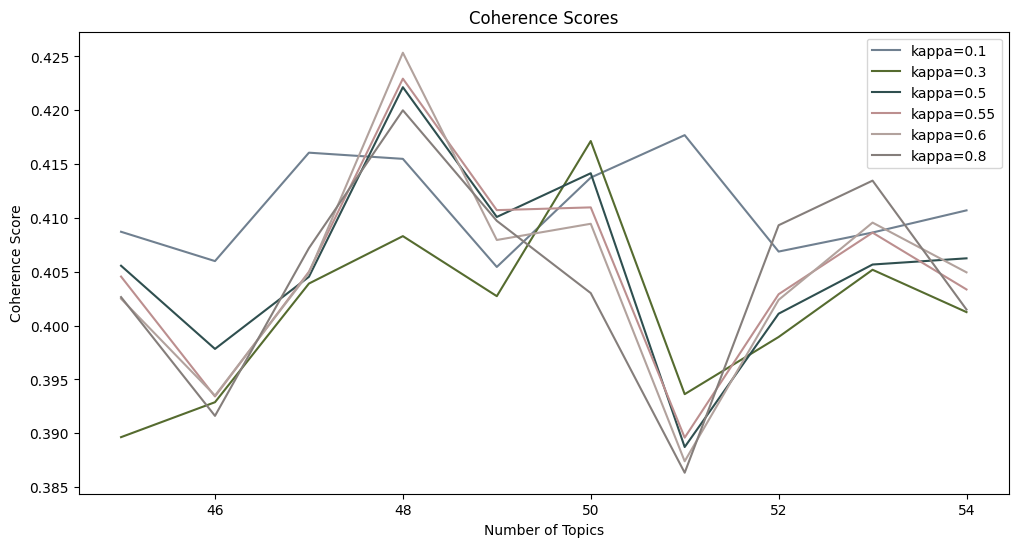

In [ ]:
plot_training(coherence_values, topic_range=range(45, 55, 1))

## Best Model

In [ ]:
nmf_model, corpus, dictionary = train(df['TOKEN'], num_topics=48, passes=5, random_state=SEED, lr=0.6)

In [ ]:
coherencemodel = CoherenceModel(model=nmf_model, corpus=corpus, texts=df['TOKEN'], dictionary=dictionary, coherence='c_v')
coherencemodel.get_coherence()

0.4253437656993167

## Concat Dataframe

In [ ]:
def format_topic(model, corpus):
    sent_topics_df = pd.DataFrame()

    # Collect
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # Dominated Topic
                wp = model.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4)]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution']

    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topic(model=nmf_model, corpus=corpus)

In [ ]:
# Concat the result to the original dataframe
df_topic_sents_keywords = pd.concat([df, df_topic_sents_keywords], axis=1)

In [ ]:
import matplotlib.pyplot as plt

def plot_distribution(df, topic_num=20):
    top_topics = df['Dominant_Topic'].value_counts().nlargest(topic_num)
    top_topic_indices = top_topics.index

    plt.figure(figsize=(12, 6))
    ax = top_topics.plot(kind='bar', color='#708090')
    ax.set_xticklabels([f'{int(label)}' for label in top_topic_indices], rotation=30, ha="right")

    plt.xlabel('Dominant Topic')
    plt.ylabel('Frequence')
    plt.title('Distribution of Top 20 Topics')
    plt.show()


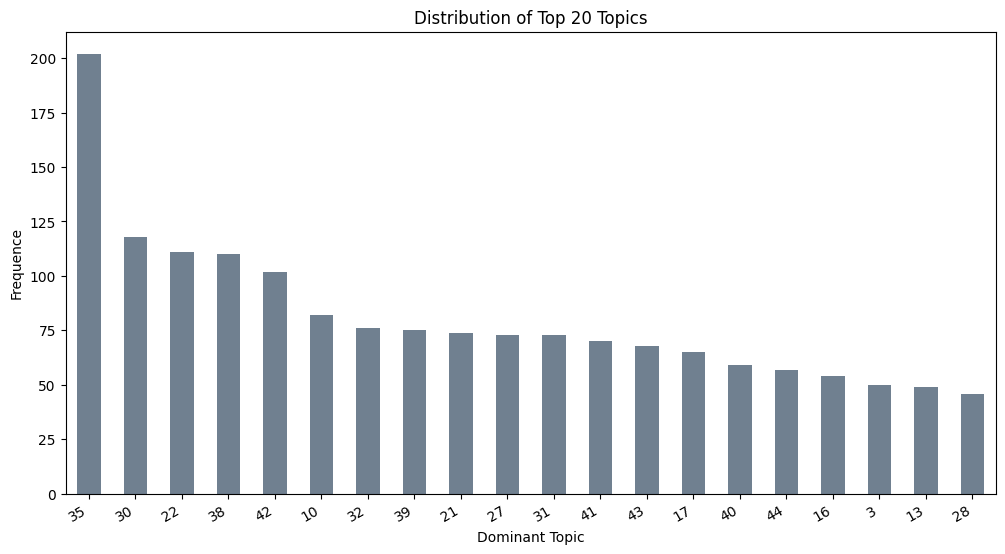

In [ ]:
plot_distribution(df_topic_sents_keywords)

In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()[:20]
print(topic_counts)

35.0    202
30.0    118
22.0    111
38.0    110
42.0    102
10.0     82
32.0     76
39.0     75
21.0     74
27.0     73
31.0     73
41.0     70
43.0     68
17.0     65
40.0     59
44.0     57
16.0     54
3.0      50
13.0     49
28.0     46
18.0     46
25.0     46
4.0      43
2.0      43
47.0     43
34.0     43
0.0      43
29.0     42
14.0     40
26.0     38
20.0     36
Name: Dominant_Topic, dtype: int64


In [ ]:
topic_df = topic_df(nmf_model)
topic_df

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,推動,工作,補助,中央,觀光,推動,爭取,建設,免費,生活,...,國家,經濟,發展,青年,問題,澎湖,提升,政策,選舉,提升
1,教育,爭取,環境,要求,臺東,保障,觀光,爭取,世界,家庭,...,台灣,政府,落實,台中,解決,提供,制定,台灣,兩岸,加強
2,制度,教育,正義,設立,經濟,兩岸,文化,地區,終身,服務,...,政治,兩岸,交通,社區,世界,免費,環境,推動,主張,教育
3,改革,保護,生活,教育,國際,觀光,規劃,補助,所得,青年,...,經濟,環境,改善,增加,能源,醫療,權益,文化,台灣,政策
4,社會,機會,公平,中心,台南,權益,經費,花蓮,工作,百姓,...,改革,弱勢,產業,教育,民主,老人,行政,政府,利益,政府
5,建立,立法,推動,爭取,打造,反對,中央,新竹,貸款,基隆,...,憲法,和平,環境,空間,人權,觀光,品質,建立,反對,問題
6,落實,增加,中央,補助,結合,立法,協助,完成,網路,革命,...,國會,督促,制度,創業,大學,國民,保障,發展,共同,建設
7,安全,倫理,社會,就業,全面,全面,落實,經費,一律,未來,...,制度,安全,投資,鼓勵,廢除,補助,改革,能源,和平,工程
8,強化,公務員,在地,大陸,產業,就業,交通,設立,窮人,健康,...,凍憲,促進,土地,提供,全球,成立,安全,農民,參與,資源
9,家庭,全民,持續,大學,美國,建設,改善,鄉親,公義,需要,...,司法,青年,確保,托育,中國,年金,工作,落實,建立,增加


In [ ]:
topic_df.to_csv('NMF_Result/topic_df.csv')

# Label Topics

In [ ]:
def process_topic_model_results(file_path):
    df = pd.read_csv(file_path)
    df.drop(df.columns[0], axis=1, inplace=True)

    df_transposed = df.T
    df_transposed.reset_index(inplace=True)
    df_transposed['keywords'] = df_transposed.apply(lambda row: row[1:].tolist(), axis=1)
    df_processed = df_transposed[['index', 'keywords']]
    df_processed.rename(columns={'index': 'Topic'}, inplace=True)

    return df_processed

In [ ]:
FP = 'NMF_Result/topic_df.csv'
topic_df = process_topic_model_results(FP)
topic_df

,Topic,keywords
0,0,"[推動, 教育, 制度, 改革, 社會, 建立, 落實, 安全, 強化, 家庭]"
1,1,"[工作, 爭取, 教育, 保護, 機會, 立法, 增加, 倫理, 公務員, 全民]"
2,2,"[補助, 環境, 正義, 生活, 公平, 推動, 中央, 社會, 在地, 持續]"
3,3,"[中央, 要求, 設立, 教育, 中心, 爭取, 補助, 就業, 大陸, 大學]"
4,4,"[觀光, 臺東, 經濟, 國際, 台南, 打造, 結合, 全面, 產業, 美國]"
5,5,"[推動, 保障, 兩岸, 觀光, 權益, 反對, 立法, 全面, 就業, 建設]"
6,6,"[爭取, 觀光, 文化, 規劃, 經費, 中央, 協助, 落實, 交通, 改善]"
7,7,"[建設, 爭取, 地區, 補助, 花蓮, 新竹, 完成, 經費, 設立, 鄉親]"
8,8,"[免費, 世界, 終身, 所得, 工作, 貸款, 網路, 一律, 窮人, 公義]"
9,9,"[生活, 家庭, 服務, 青年, 百姓, 基隆, 革命, 未來, 健康, 需要]"


In [ ]:
topic_label = {1: "教育制度改革與社會安全強化", 2: "教育機會保護與公務員倫理立法", 3: "環境正義與社會公平推動", 4: "教育資源中心建設與就業機會增強", 5: "台東與台南的觀光經濟與國際合作", 6: "兩岸關係與觀光產業發展", 7: "文化觀光規劃與交通基礎設施改善", 8: "花蓮與新竹地區建設與社區發展", 9: "全球免費終身教育與網路公義", 10: "家庭生活服務與基隆市青年發展",
               11: "觀光資源推動與產業環境提升", 12: "地方資源落實與經濟醫療發展", 13: "社會建設與台灣大學教育強化", 14: "政府社會督促與國民服務改進", 15: "文化照顧與基隆市觀光發展", 16: "持續發展制度與服務權益完善", 17: "高雄產業提升與社區文化發展", 18: "地方安全保障與服務品質提升", 19: "台灣與高雄的未來產業發展與就業機會", 20: "中華民國主權與澎湖地區發展",
               21: "社會經濟發展與地方產業增強", 22: "馬祖區域計畫實施與基礎建設完善", 23: "老人福利保障與安全制度建立", 24: "雲林地區發展與多元族群權益保障", 25: "金門兩岸和平發展與鄉村醫療改善", 26: "全面家庭政策與教育預算改革", 27: "台灣勞工保障與就業改善", 28: "台灣國際地位與民主獨立發展", 29: "政治改革與社會責任", 30: "板橋區未來發展與捷運建設",
               31: "社會福利與兩岸就業權益保障", 32: "台灣教育與文化發展", 33: "雲林農業發展與科技農村觀光", 34: "產業國際化與政府開放政策", 35: "地方生活權益與政府監督", 36: "國會改革與專業選區監督", 37: "文化與經濟發展的國際推動", 38: "台灣國家認同與中華民國主權", 39: "台灣政治與經濟憲法改革", 40: "經濟與環境平衡的兩岸和平發展",
               41: "綜合交通發展與產業環境改善", 42: "台中青年教育與社區創業發展", 43: "全球能源與民主人權問題解決", 44: "澎湖醫療與觀光產業支持", 45: "環境權益與行政品質提升", 46: "台灣文化與能源政策推動", 47: "兩岸和平與台灣選舉主張", 48: "教育與政府政策提升工程"}

In [ ]:
topic_df['Topic'] = topic_df['Topic'].astype('int')
topic_df['Topic'] += 1
topic_df.insert(1, 'Topic_Label', topic_df['Topic'].map(topic_label))

In [ ]:
topic_df

,Topic,Topic_Label,keywords
0,1,教育制度改革與社會安全強化,"[推動, 教育, 制度, 改革, 社會, 建立, 落實, 安全, 強化, 家庭]"
1,2,教育機會保護與公務員倫理立法,"[工作, 爭取, 教育, 保護, 機會, 立法, 增加, 倫理, 公務員, 全民]"
2,3,環境正義與社會公平推動,"[補助, 環境, 正義, 生活, 公平, 推動, 中央, 社會, 在地, 持續]"
3,4,教育資源中心建設與就業機會增強,"[中央, 要求, 設立, 教育, 中心, 爭取, 補助, 就業, 大陸, 大學]"
4,5,台東與台南的觀光經濟與國際合作,"[觀光, 臺東, 經濟, 國際, 台南, 打造, 結合, 全面, 產業, 美國]"
5,6,兩岸關係與觀光產業發展,"[推動, 保障, 兩岸, 觀光, 權益, 反對, 立法, 全面, 就業, 建設]"
6,7,文化觀光規劃與交通基礎設施改善,"[爭取, 觀光, 文化, 規劃, 經費, 中央, 協助, 落實, 交通, 改善]"
7,8,花蓮與新竹地區建設與社區發展,"[建設, 爭取, 地區, 補助, 花蓮, 新竹, 完成, 經費, 設立, 鄉親]"
8,9,全球免費終身教育與網路公義,"[免費, 世界, 終身, 所得, 工作, 貸款, 網路, 一律, 窮人, 公義]"
9,10,家庭生活服務與基隆市青年發展,"[生活, 家庭, 服務, 青年, 百姓, 基隆, 革命, 未來, 健康, 需要]"


In [ ]:
topic_df.to_csv('NMF_Result/Fine_tuning_Result.csv')

In [ ]:
Pork = set([4, 7, 9, 14, 16, 18, 19, 21, 23, 24, 29, 32, 41, 43])
df_topic_sents_keywords['PORK'] = df_topic_sents_keywords['Dominant_Topic'].apply(lambda x: 1 if x in Pork else 0)

In [ ]:
df_topic_sents_keywords.head(2)

# Visualization

In [ ]:
# Visualization function, make sure the dataframe contains 'TH', 'PORK' columns
def visualization(df, model, party, y_axis, reform_year=2005, save=False):
    print(f'Numebr of candidates: {len(df)}')

    if reform_year == 2005:
        country = 'Taiwan'
    else:
        country = 'Japan'

    grouped = df.groupby('TH')

    pork_ratios = grouped['PORK'].mean()
    policy_ratios = 1 - pork_ratios

    result_df = pd.DataFrame({
        'TH': pork_ratios.index,
        'PORK': pork_ratios.values,
        'POLICY': policy_ratios.values
    })

    print(result_df)

    fig, ax1 = plt.subplots(figsize=(10, 7))

    result_df.plot(x='TH', y='PORK', kind='line', ax=ax1, label='PORK', color='orange', marker='o')
    for i, j in zip(result_df['TH'], result_df['PORK']):
        ax1.annotate(f'{j:.2f}', (i, j))

    ax2 = ax1.twinx()

    result_df.plot(x='TH', y='POLICY', kind='line', ax=ax2, label='POLICY', marker='s')
    for i, j in zip(result_df['TH'], result_df['POLICY']):
        ax2.annotate(f'{j:.2f}', (i, j))

    ax1.set_title(f'Pork and Policy Ratio of {party} Candidates by {model} Algorithm')
    ax1.set_xlabel('Election Year')

    ax2.axvline(x=6.25, color='black', linestyle='--')
    ax2.annotate('Electoral Reform', xy=(6.25, y_axis), xytext=(6.35, y_axis+0.02),
                arrowprops=dict(facecolor='black', arrowstyle='->'), xycoords='data')

    th_year_dict = {4: "1998", 5: "2001", 6: "2004", 7: "2008", 8: "2012",
                    9: "2016", 10: "2020"}

    ax2.set_xticks(result_df['TH'])
    new_xticks = [f"{int(th)}\n({th_year_dict[th]})" for th in result_df['TH']]
    ax2.set_xticklabels(new_xticks)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='best')

    if save:
        plt.savefig(f'Graph/{country}_Pork-Policy_{model}_{party}.png')
    else:
        plt.show()

Numebr of candidates: 2489
   TH      PORK    POLICY
0   4  0.101828  0.898172
1   5  0.152074  0.847926
2   6  0.241848  0.758152
3   7  0.268551  0.731449
4   8  0.398496  0.601504
5   9  0.344928  0.655072
6  10  0.382927  0.617073


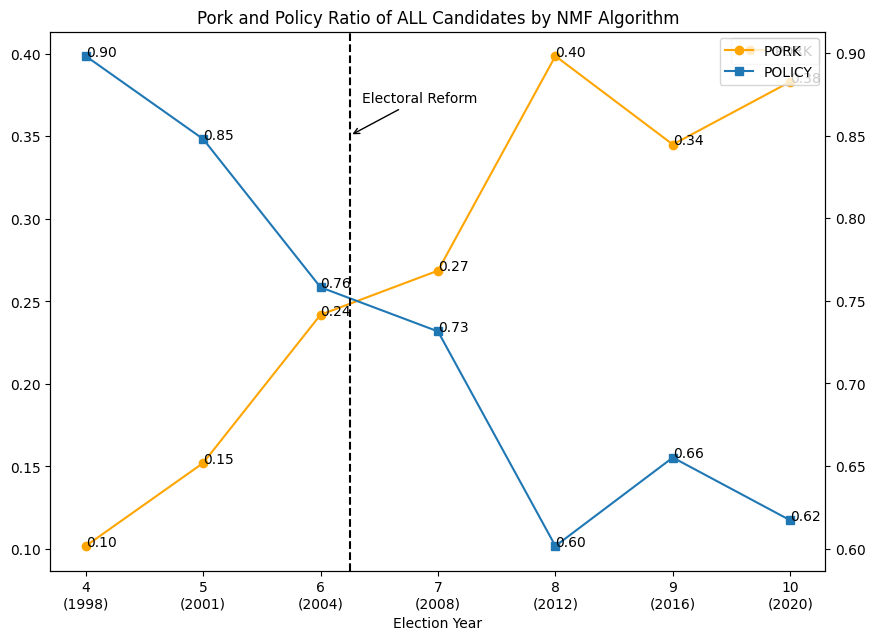

In [ ]:
visualization(df_topic_sents_keywords, model="NMF", party="ALL", y_axis=0.85)